In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# Visualization settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

In [3]:
# Load the CSV files
history_df = pd.read_csv("TCS_stock_history.csv")
action_df = pd.read_csv("TCS_stock_action.csv")

# Convert 'Date' columns to datetime
history_df['Date'] = pd.to_datetime(history_df['Date'])
action_df['Date'] = pd.to_datetime(action_df['Date'])

# Merge on Date
tcs_df = pd.merge(history_df, action_df, on='Date', how='left')

# Fill missing dividends/stock splits with 0
tcs_df['Dividends_y'] = tcs_df['Dividends_y'].fillna(0)
tcs_df['Stock Splits_y'] = tcs_df['Stock Splits_y'].fillna(0)

# Rename columns
tcs_df.rename(columns={
    'Dividends_x': 'Daily Dividends',
    'Stock Splits_x': 'Daily Stock Splits',
    'Dividends_y': 'Event Dividends',
    'Stock Splits_y': 'Event Stock Splits'
}, inplace=True)

# Sort by date
tcs_df = tcs_df.sort_values(by='Date').reset_index(drop=True)

# View data
tcs_df.head()

,Date,Open,High,Low,Close,Volume,Daily Dividends,Daily Stock Splits,Event Dividends,Event Stock Splits
0,2002-08-12,28.794172,29.742206,28.794172,29.519140,212976,0.0,0.0,0.0,0.0
1,2002-08-13,29.556316,30.030333,28.905705,29.119476,153576,0.0,0.0,0.0,0.0
2,2002-08-14,29.184536,29.184536,26.563503,27.111877,822776,0.0,0.0,0.0,0.0
3,2002-08-15,27.111877,27.111877,27.111877,27.111877,0,0.0,0.0,0.0,0.0
4,2002-08-16,26.972458,28.255089,26.582090,27.046812,811856,0.0,0.0,0.0,0.0


In [4]:
df = pd.read_csv("TCS_stock_history.csv")
df = pd.read_csv("TCS_stock_action.csv")
df.columns

Index(['Date', 'Dividends', 'Stock Splits'], dtype='object')

In [5]:
 df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          70 non-null     object 
 1   Dividends     70 non-null     float64
 2   Stock Splits  70 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.8+ KB


In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df.describe()  

,Date,Dividends,Stock Splits
count,70,70.000000,70.000000
mean,2013-05-10 13:42:51.428571392,4.560714,0.085714
min,2004-10-28 00:00:00,0.375000,0.000000
25%,2009-03-03 18:00:00,1.000000,0.000000
50%,2013-07-02 12:00:00,2.500000,0.000000
75%,2017-07-13 18:00:00,5.000000,0.000000
max,2021-07-15 00:00:00,40.000000,2.000000
std,NaN,6.284794,0.407995


In [7]:
corel=df.corr()
corel

,Date,Dividends,Stock Splits
Date,1.000000,0.558649,-0.080974
Dividends,0.558649,1.000000,0.027614
Stock Splits,-0.080974,0.027614,1.000000


In [8]:
# Calculate correlation of all numeric columns with 'Close'
correlation_with_close = tcs_df.corr(numeric_only=True)['Close'].sort_values(ascending=False)

# Print the correlation values
print("📊 Correlation of Features with Close Price:\n")
print(correlation_with_close)

📊 Correlation of Features with Close Price:

Close                 1.000000
High                  0.999914
Low                   0.999901
Open                  0.999787
Daily Dividends       0.060179
Event Dividends       0.060179
Daily Stock Splits   -0.006635
Event Stock Splits   -0.006635
Volume               -0.152844
Name: Close, dtype: float64


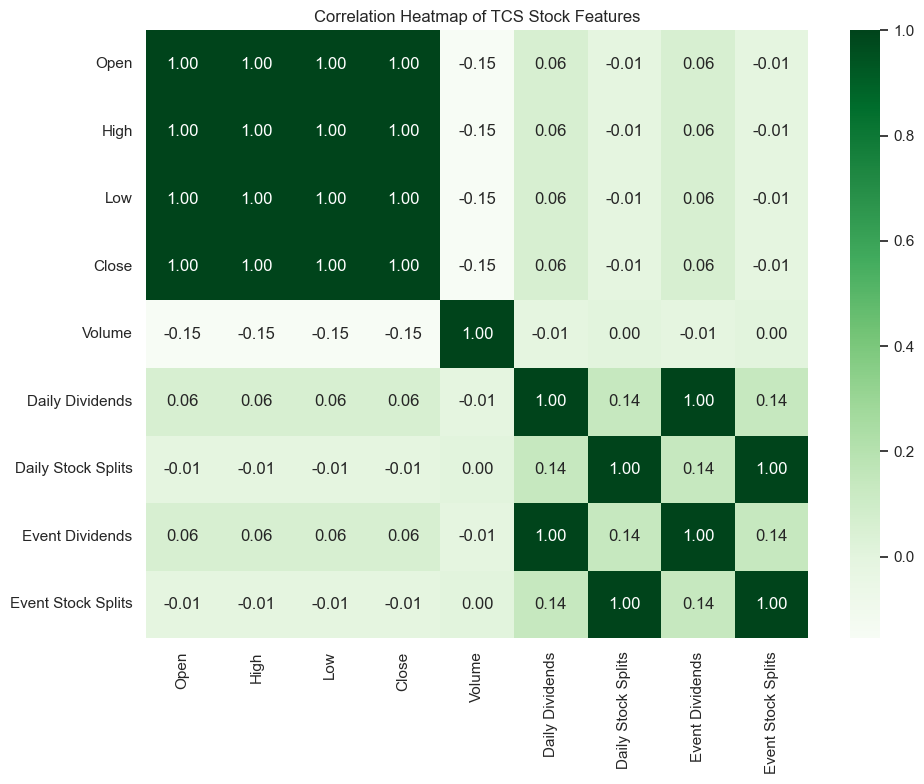

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(tcs_df.corr(numeric_only=True), annot=True, cmap='Greens', fmt=".2f")
plt.title("Correlation Heatmap of TCS Stock Features")
plt.tight_layout()
plt.show()

In [10]:
# Check for missing values in the merged DataFrame
tcs_df.isnull().sum()

Date                  0
Open                  0
High                  0
Low                   0
Close                 0
Volume                0
Daily Dividends       0
Daily Stock Splits    0
Event Dividends       0
Event Stock Splits    0
dtype: int64

In [11]:
# Fill any remaining nulls in numeric columns with 0 (if appropriate)
tcs_df.fillna(0, inplace=True)

In [12]:
# Confirm data types
tcs_df.dtypes

Date                  datetime64[ns]
Open                         float64
High                         float64
Low                          float64
Close                        float64
Volume                         int64
Daily Dividends              float64
Daily Stock Splits           float64
Event Dividends              float64
Event Stock Splits           float64
dtype: object

In [13]:
# Convert columns to numeric if needed
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 
                'Daily Dividends', 'Daily Stock Splits', 
                'Event Dividends', 'Event Stock Splits']

for col in numeric_cols:
    tcs_df[col] = pd.to_numeric(tcs_df[col], errors='coerce')

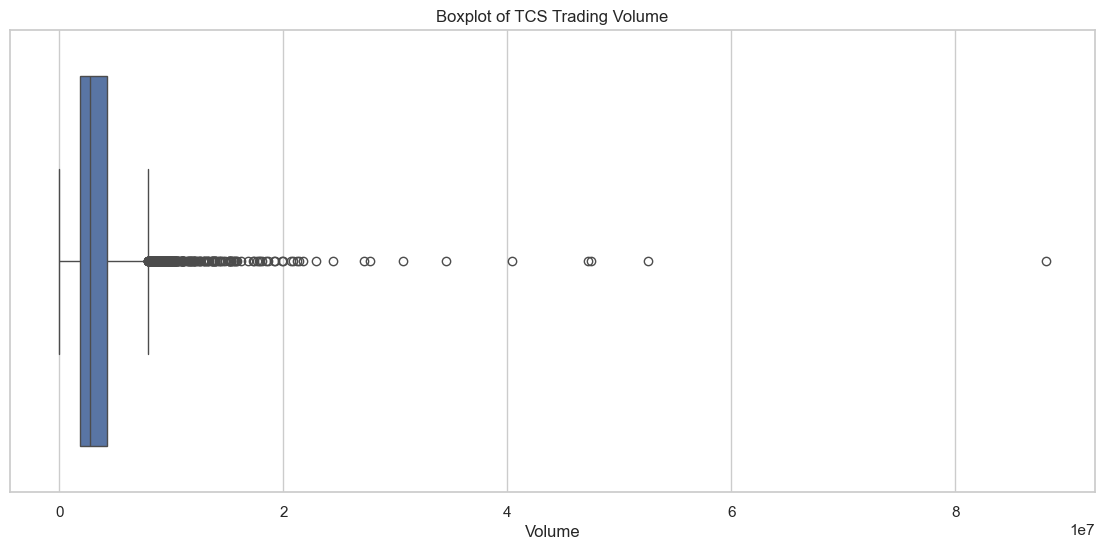

In [14]:
sns.boxplot(x=tcs_df['Volume'])
plt.title("Boxplot of TCS Trading Volume")
plt.show()

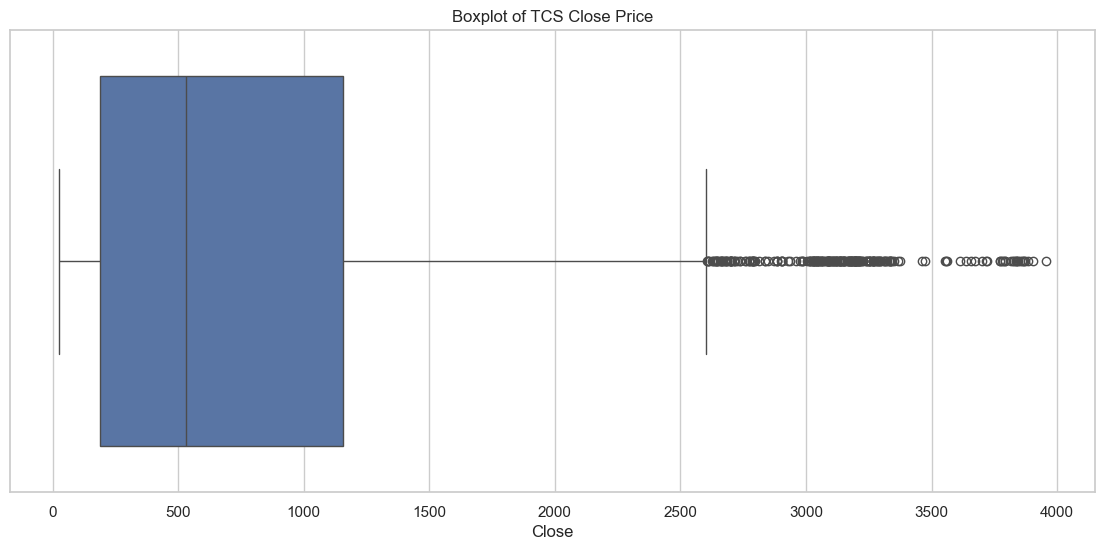

In [15]:
sns.boxplot(x=tcs_df['Close'])
plt.title("Boxplot of TCS Close Price")
plt.show()

In [16]:
# Define function to detect outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

# Remove outliers in Volume and Close
tcs_clean_df = remove_outliers(tcs_df, 'Volume')
tcs_clean_df = remove_outliers(tcs_clean_df, 'Close')

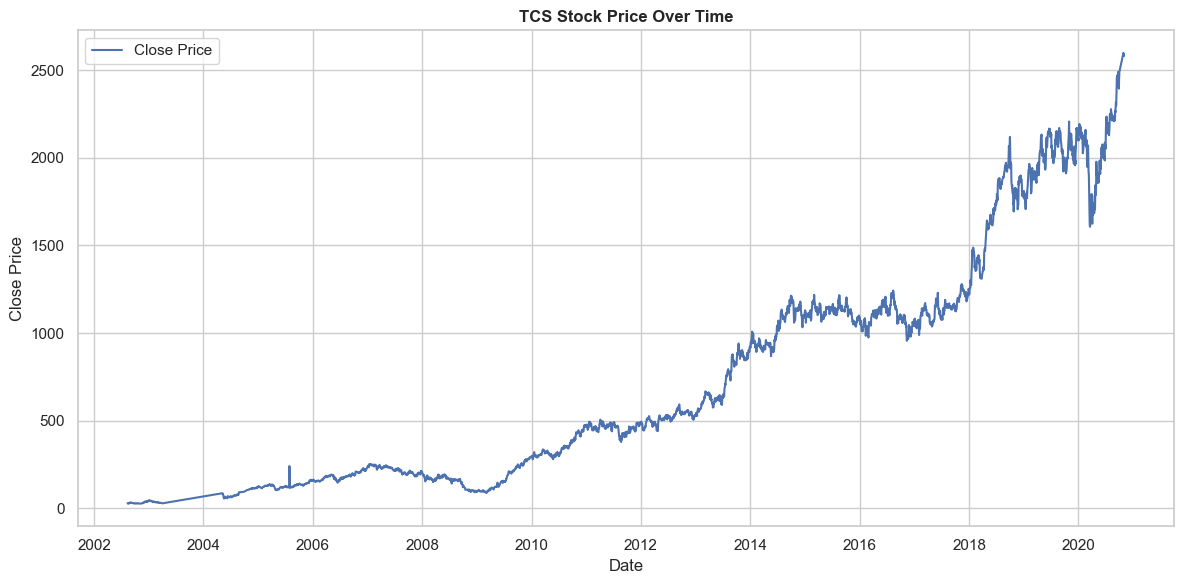

In [17]:
# Plot Close Price over time from your actual DataFrame
plt.figure(figsize=(12, 6))
plt.plot(tcs_clean_df['Date'], tcs_clean_df['Close'], label='Close Price', color='b')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('TCS Stock Price Over Time', weight='bold')
plt.legend()
plt.tight_layout()
plt.show()

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Daily Dividends', 'Daily Stock Splits', 'Event Dividends', 'Event Stock Splits']


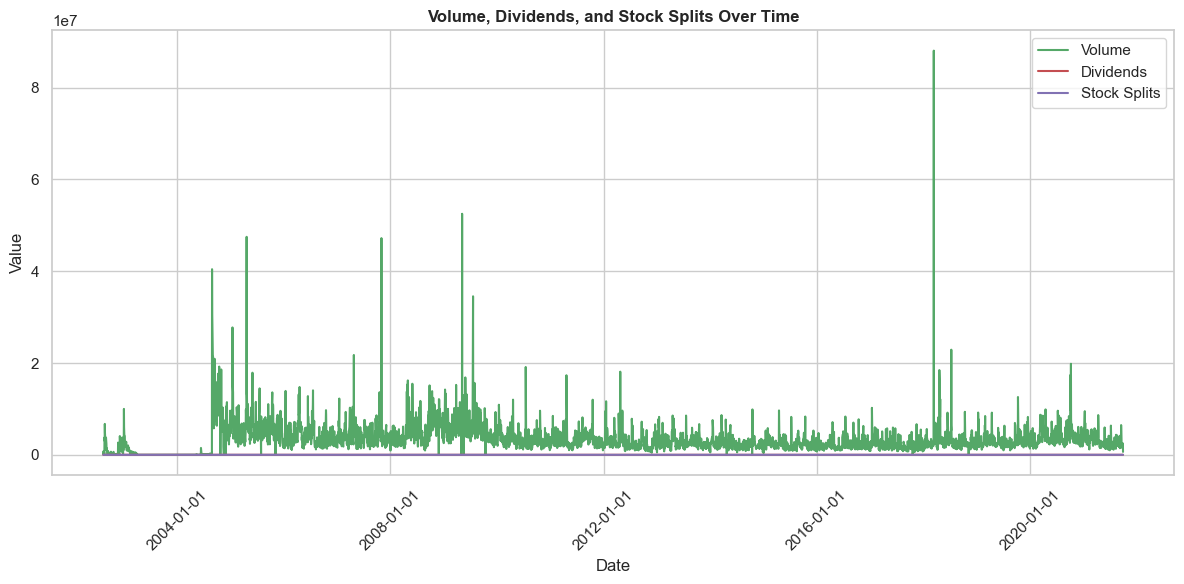

In [18]:
# Step 1: Check columns
print(tcs_df.columns.tolist())

# Step 2: Strip whitespace in column names
tcs_df.columns = tcs_df.columns.str.strip()

# Step 3: Rename for simplicity 
tcs_df.rename(columns={
    'Daily Dividends': 'Dividends',
    'Daily Stock Splits': 'Stock Splits'
}, inplace=True)

# Step 4: Plot with the correct column names
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

tcs_df['Date'] = pd.to_datetime(tcs_df['Date'])
tcs_df = tcs_df.sort_values('Date')

plt.figure(figsize=(12, 6))
plt.plot(tcs_df['Date'], tcs_df['Volume'], label='Volume', color='g')
plt.plot(tcs_df['Date'], tcs_df['Dividends'], label='Dividends', color='r')
plt.plot(tcs_df['Date'], tcs_df['Stock Splits'], label='Stock Splits', color='m')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Volume, Dividends, and Stock Splits Over Time', weight='bold')
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

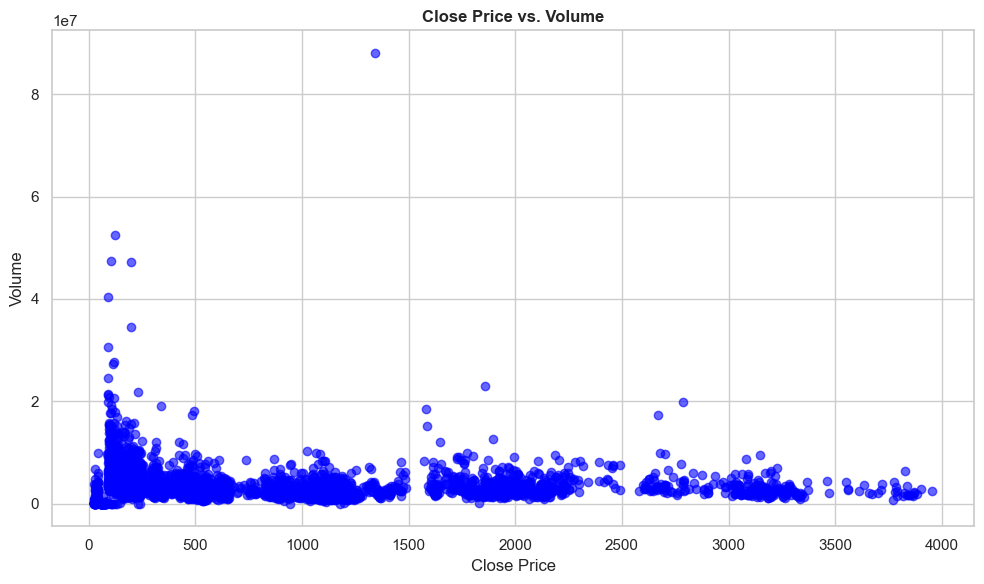

In [19]:
# Rename Close_x to Close
tcs_df.rename(columns={'Close_x': 'Close'}, inplace=True)

# Then plot
plt.figure(figsize=(10, 6))
plt.scatter(tcs_df['Close'], tcs_df['Volume'], alpha=0.6, color='blue')
plt.xlabel('Close Price')
plt.ylabel('Volume')
plt.title('Close Price vs. Volume', weight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

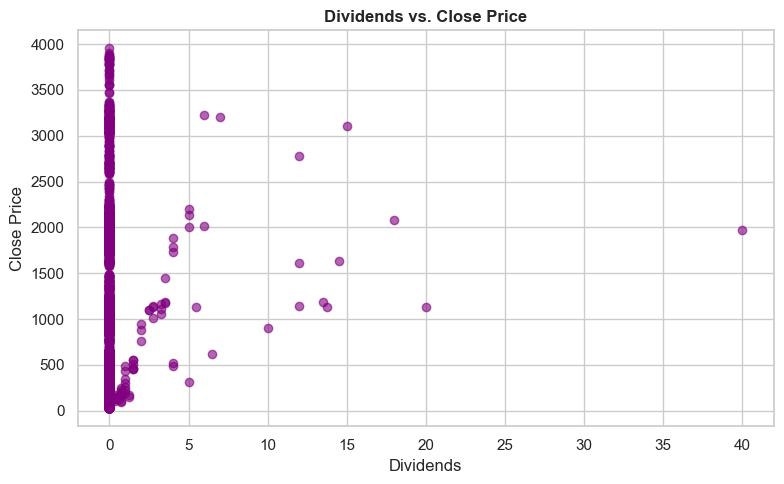

In [20]:
# Make sure Date is datetime and data is sorted
tcs_df['Date'] = pd.to_datetime(tcs_df['Date'])
tcs_df = tcs_df.sort_values('Date')

# Scatter plot with the right column names
plt.figure(figsize=(8, 5))
plt.scatter(tcs_df['Dividends'], tcs_df['Close'], alpha=0.6, color='purple')
plt.xlabel('Dividends')
plt.ylabel('Close Price')
plt.title('Dividends vs. Close Price', weight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Event Dividends', 'Event Stock Splits']


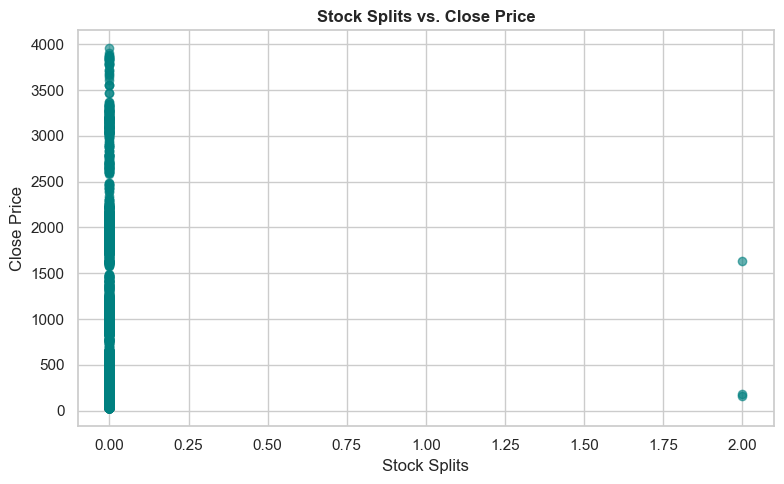

In [21]:
# Check for correct column names before plotting
print(tcs_df.columns.tolist())  # Run this if you're unsure

# Example using common column names
plt.figure(figsize=(8, 5))
plt.scatter(tcs_df['Stock Splits'], tcs_df['Close'], alpha=0.6, color='teal')
plt.xlabel('Stock Splits')
plt.ylabel('Close Price')
plt.title('Stock Splits vs. Close Price', weight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

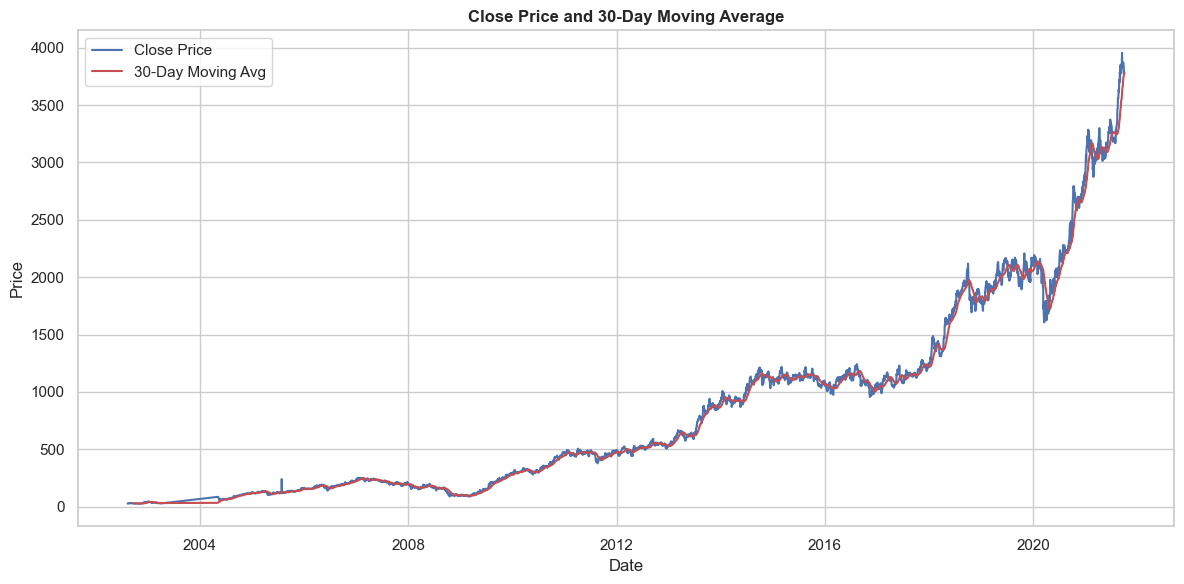

In [22]:
# Ensure Date is datetime and sorted
tcs_df['Date'] = pd.to_datetime(tcs_df['Date'])
tcs_df = tcs_df.sort_values('Date')

# If column is 'Close_x', rename it for consistency
tcs_df.rename(columns={'Close_x': 'Close'}, inplace=True)

# Calculate 30-day moving average
tcs_df['30-Day Moving Avg'] = tcs_df['Close'].rolling(window=30).mean()

# Plot Close price and moving average
plt.figure(figsize=(12, 6))
plt.plot(tcs_df['Date'], tcs_df['Close'], label='Close Price', color='b')
plt.plot(tcs_df['Date'], tcs_df['30-Day Moving Avg'], label='30-Day Moving Avg', color='r')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Close Price and 30-Day Moving Average', weight='bold')
plt.legend()
plt.tight_layout()
plt.show()

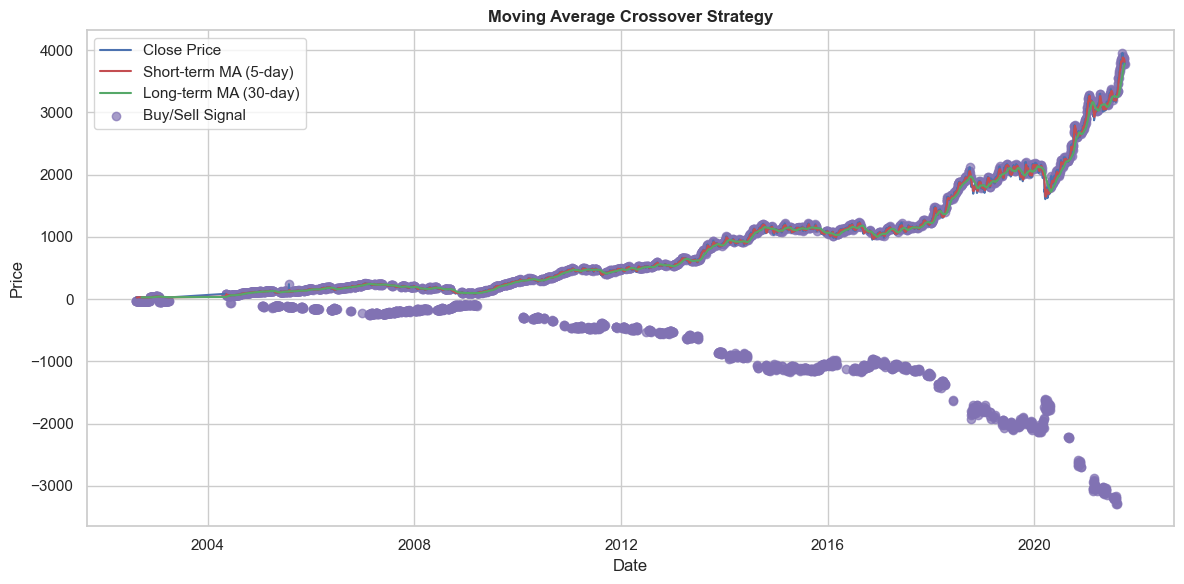

In [23]:
# Ensure correct column names and sorting
tcs_df['Date'] = pd.to_datetime(tcs_df['Date'])
tcs_df = tcs_df.sort_values('Date')

# Rename column
tcs_df.rename(columns={'Close_x': 'Close'}, inplace=True)

# Calculate short-term and long-term moving averages
tcs_df['Short_MA'] = tcs_df['Close'].rolling(window=5).mean()
tcs_df['Long_MA'] = tcs_df['Close'].rolling(window=30).mean()

# Generate buy/sell signals
tcs_df['Signal'] = np.where(tcs_df['Short_MA'] > tcs_df['Long_MA'], 1, -1)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(tcs_df['Date'], tcs_df['Close'], label='Close Price', color='b')
plt.plot(tcs_df['Date'], tcs_df['Short_MA'], label='Short-term MA (5-day)', color='r')
plt.plot(tcs_df['Date'], tcs_df['Long_MA'], label='Long-term MA (30-day)', color='g')
plt.scatter(tcs_df['Date'], tcs_df['Close'] * tcs_df['Signal'], 
            label='Buy/Sell Signal', marker='o', color='m', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Moving Average Crossover Strategy', weight='bold')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

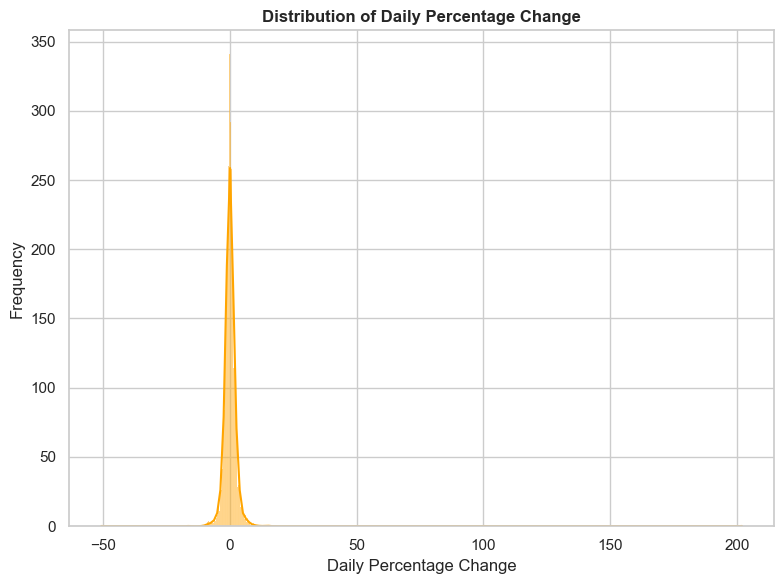

In [24]:
# Ensure 'Date' is datetime and data is sorted
tcs_df['Date'] = pd.to_datetime(tcs_df['Date'])
tcs_df = tcs_df.sort_values('Date')

# Rename Close_x to Close
if 'Close_x' in tcs_df.columns:
    tcs_df.rename(columns={'Close_x': 'Close'}, inplace=True)

# Calculate daily price percentage change
tcs_df['Daily_Price_Change'] = tcs_df['Close'].pct_change() * 100

# Plot histogram of daily percentage changes
plt.figure(figsize=(8, 6))
sns.histplot(tcs_df['Daily_Price_Change'].dropna(), kde=True, color='orange')
plt.xlabel('Daily Percentage Change')
plt.ylabel('Frequency')
plt.title('Distribution of Daily Percentage Change', weight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
# Load stock data
df = pd.read_csv("TCS_stock_history.csv")

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort by Date just in case
df = df.sort_values('Date')
df['Moving_Avg_Close'] = df['Close'].rolling(window=7).mean()
df.shape

(4463, 9)

Mean Absolute Error: 26.2287


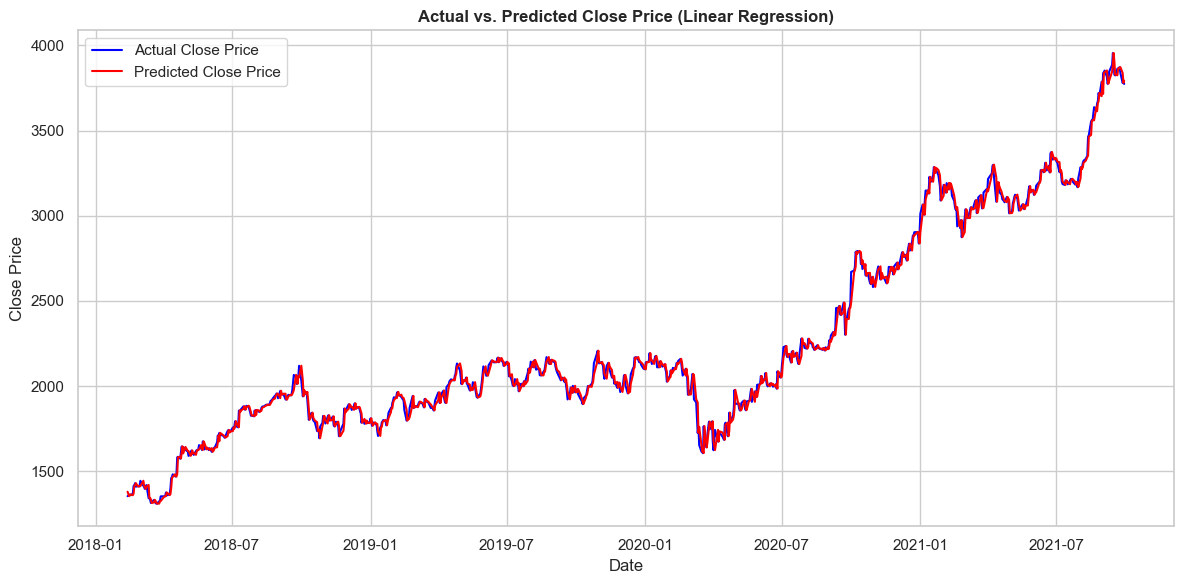

In [26]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv("TCS_stock_history.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Create a new target column: next day's Close price
df['Close_next'] = df['Close'].shift(-1)
df = df.dropna()

# Features and target
X = df[['Close']].values
y = df['Close_next'].values

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
split_index = int(len(df) * 0.8)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
dates_test = df['Date'].iloc[split_index:]

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
lstm_predictions = model.predict(X_test)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, lstm_predictions)
print(f"Mean Absolute Error: {mae:.4f}")

# Save predictions with date
predictions_df = pd.DataFrame({
    'Date': dates_test.values,
    'Predicted_Close': lstm_predictions
})
predictions_df.to_csv('TCS_lstm_predictions.csv', index=False)

# Optional: Plot
plt.figure(figsize=(12, 6))
plt.plot(dates_test.values, y_test, label='Actual Close Price', color='blue')
plt.plot(dates_test.values, lstm_predictions, label='Predicted Close Price', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Price (Linear Regression)', weight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

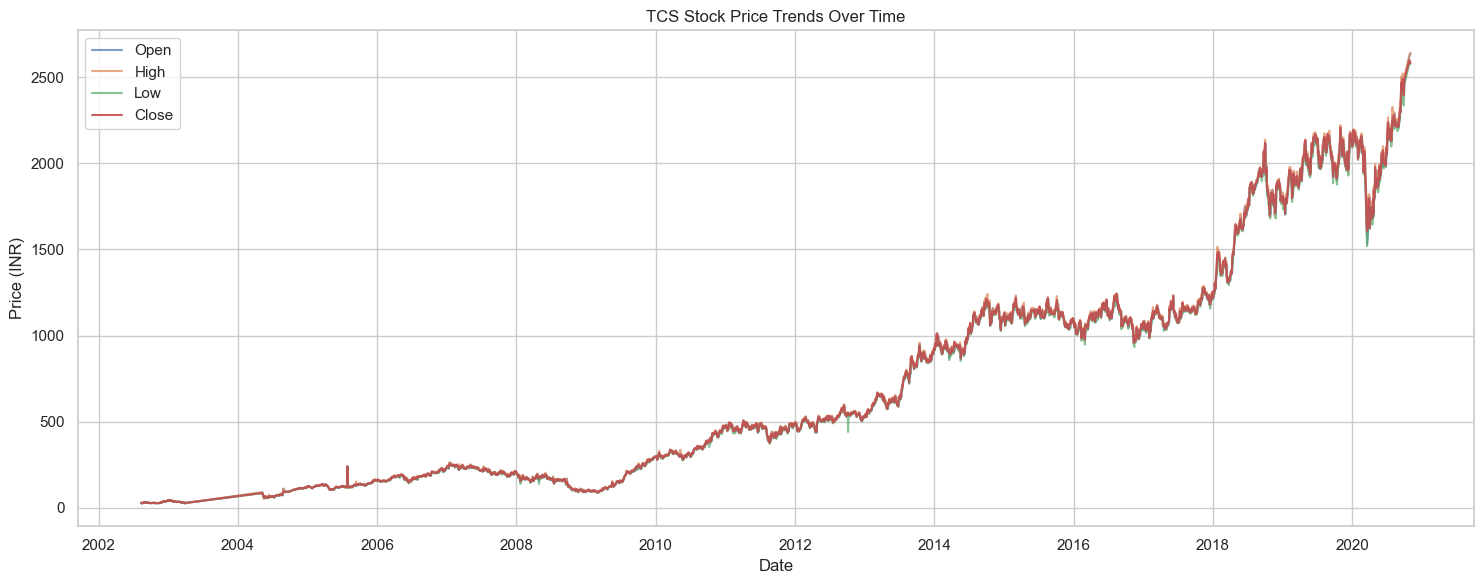

In [27]:
# Plot Open, High, Low, and Close prices over time
plt.figure(figsize=(15,6))
plt.plot(tcs_clean_df['Date'], tcs_clean_df['Open'], label='Open', alpha=0.7)
plt.plot(tcs_clean_df['Date'], tcs_clean_df['High'], label='High', alpha=0.7)
plt.plot(tcs_clean_df['Date'], tcs_clean_df['Low'], label='Low', alpha=0.7)
plt.plot(tcs_clean_df['Date'], tcs_clean_df['Close'], label='Close', alpha=0.9)
plt.title('TCS Stock Price Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

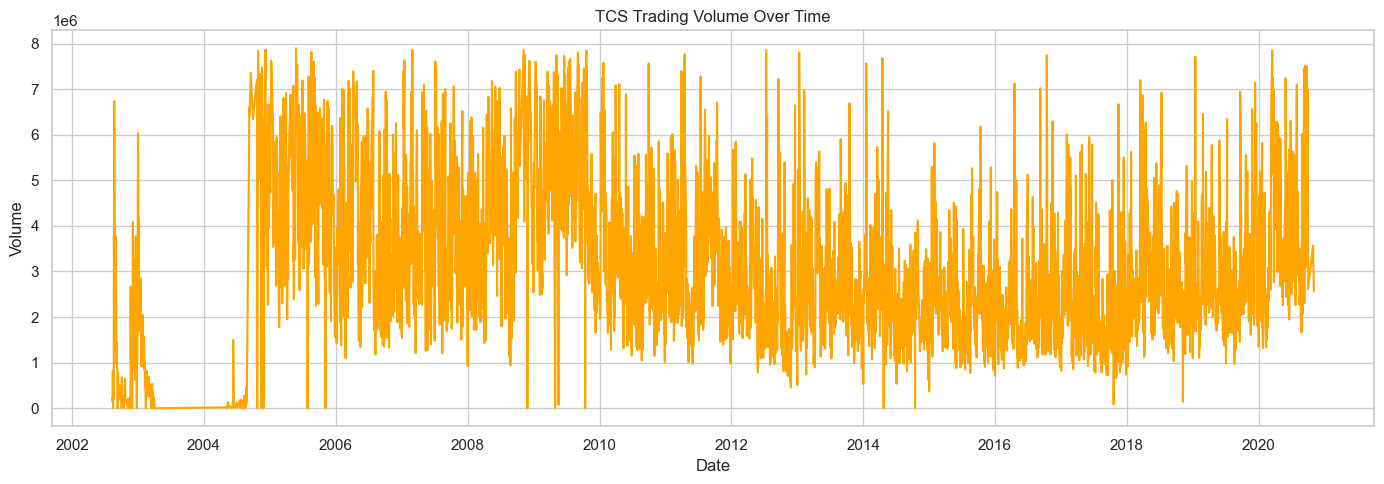

In [28]:
# Line plot of trading volume
plt.figure(figsize=(14,5))
plt.plot(tcs_clean_df['Date'], tcs_clean_df['Volume'], color='orange')
plt.title("TCS Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.grid(True)
plt.tight_layout()
plt.show()

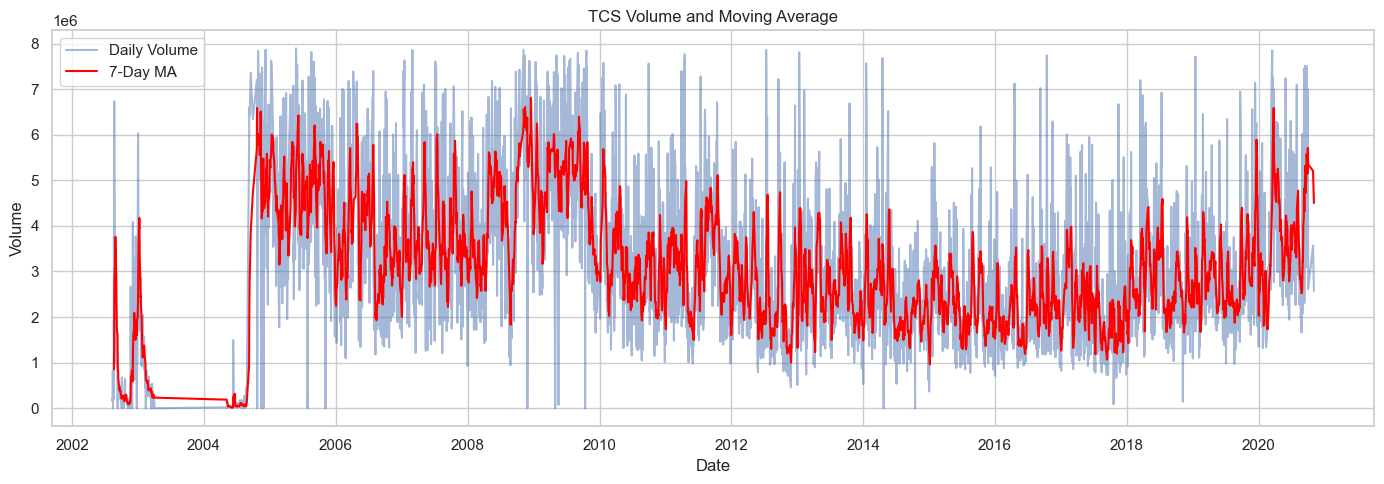

In [29]:
# Add 7-day volume moving average
tcs_clean_df['Volume_MA7'] = tcs_clean_df['Volume'].rolling(window=7).mean()

# Plot volume with MA
plt.figure(figsize=(14,5))
plt.plot(tcs_clean_df['Date'], tcs_clean_df['Volume'], label='Daily Volume', alpha=0.5)
plt.plot(tcs_clean_df['Date'], tcs_clean_df['Volume_MA7'], label='7-Day MA', color='red')
plt.title("TCS Volume and Moving Average")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

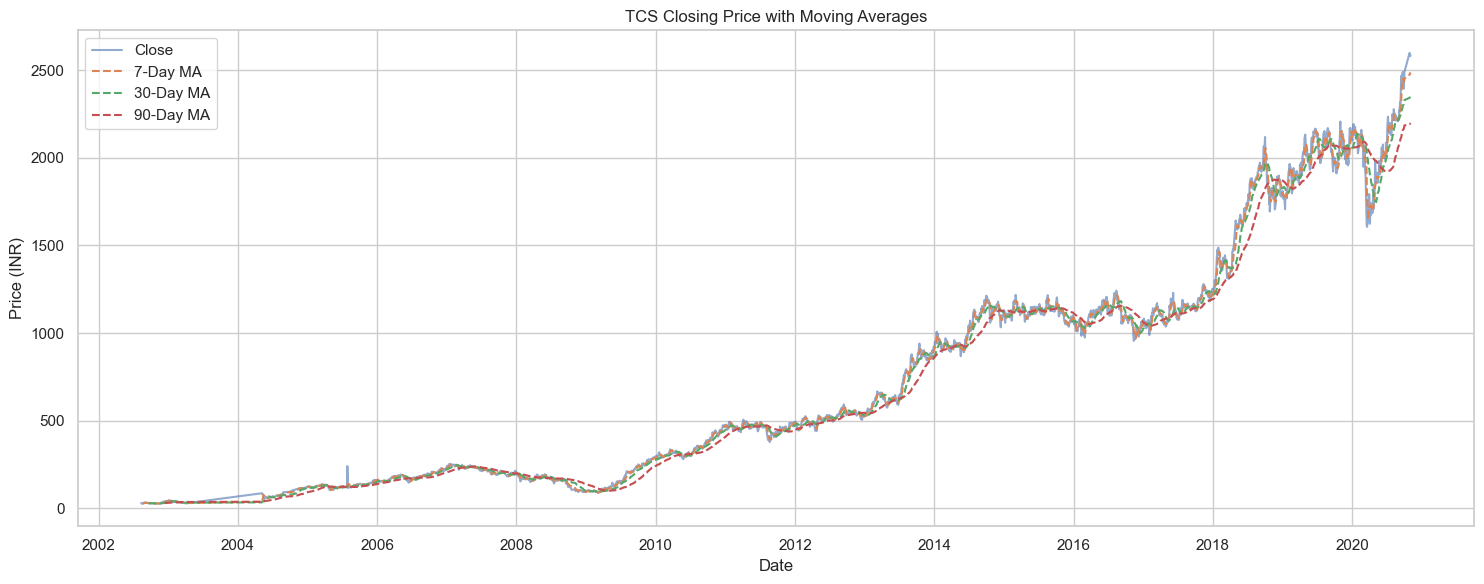

In [30]:
# Calculate moving averages
tcs_clean_df['MA_7'] = tcs_clean_df['Close'].rolling(window=7).mean()
tcs_clean_df['MA_30'] = tcs_clean_df['Close'].rolling(window=30).mean()
tcs_clean_df['MA_90'] = tcs_clean_df['Close'].rolling(window=90).mean()

# Plot close price with MAs
plt.figure(figsize=(15,6))
plt.plot(tcs_clean_df['Date'], tcs_clean_df['Close'], label='Close', alpha=0.6)
plt.plot(tcs_clean_df['Date'], tcs_clean_df['MA_7'], label='7-Day MA', linestyle='--')
plt.plot(tcs_clean_df['Date'], tcs_clean_df['MA_30'], label='30-Day MA', linestyle='--')
plt.plot(tcs_clean_df['Date'], tcs_clean_df['MA_90'], label='90-Day MA', linestyle='--')
plt.title("TCS Closing Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
# Ensure 'Date' is in datetime format
tcs_clean_df['Date'] = pd.to_datetime(tcs_clean_df['Date'])

# 📅 Extract time-based features
tcs_clean_df['Year'] = tcs_clean_df['Date'].dt.year
tcs_clean_df['Month'] = tcs_clean_df['Date'].dt.month
tcs_clean_df['Day'] = tcs_clean_df['Date'].dt.day
tcs_clean_df['Day_of_Week'] = tcs_clean_df['Date'].dt.dayofweek  # Monday=0, Sunday=6
# Create lag features for previous day's data
tcs_clean_df['Prev_Close'] = tcs_clean_df['Close'].shift(1)
tcs_clean_df['Prev_Open'] = tcs_clean_df['Open'].shift(1)
tcs_clean_df['Prev_High'] = tcs_clean_df['High'].shift(1)
tcs_clean_df['Prev_Low'] = tcs_clean_df['Low'].shift(1)
tcs_clean_df['Prev_Volume'] = tcs_clean_df['Volume'].shift(1)
# Drop rows with NaN values created by shifting
tcs_clean_df.dropna(inplace=True)
# Show key engineered features
tcs_clean_df[['Date', 'Close', 'Prev_Close', 'Year', 'Month', 'Day', 'Day_of_Week']].head()

,Date,Close,Prev_Close,Year,Month,Day,Day_of_Week
89,2002-12-13,39.101696,38.943684,2002,12,13,4
90,2002-12-16,37.419407,39.101696,2002,12,16,0
91,2002-12-17,36.731621,37.419407,2002,12,17,1
92,2002-12-18,36.387711,36.731621,2002,12,18,2
93,2002-12-19,39.464172,36.387711,2002,12,19,3


In [ ]:

                                                                    ### Conclusion ###

In this project, we conducted a comprehensive analysis of Tata Consultancy Services (TCS) stock data using various data science techniques. We began 
with data preprocessing and exploratory data analysis (EDA) to uncover trends and patterns in the historical stock prices. Visualization techniques 
provided deeper insights into price movements, volatility, and trends.

Subsequently, we employed machine learning models for forecasting future stock prices. Depending on the models used (e.g., Linear Regression, ARIMA), 
we evaluated their performance using appropriate metrics such as RMSE or MAE. The predictions provided a glimpse into the expected behavior of 
TCS stock, offering valuable insights for potential investors and analysts.

Overall, this project demonstrates the power of data analysis and machine learning in financial forecasting, showcasing practical applications in 
stock market prediction.



In [ ]:

                                    ### 🔮 Future Enhancements with Stakeholder Business Benefits ###

Integration of Real-Time Stock Data Feeds

Enhancement: Incorporate real-time TCS stock data using APIs like Alpha Vantage or Yahoo Finance.

Business Benefit: Enables timely decision-making for traders and investors, improving responsiveness to market changes and enhancing competitive 
advantage.

Predictive Modeling Using Advanced Algorithms

Enhancement: Apply advanced models such as Linear Regression , Prophet, or hybrid models combining statistical and deep learning techniques.

Business Benefit: Delivers more accurate forecasts, supporting better risk management, optimized investment strategies, and data-driven decision-
making.

Incorporation of Sentiment Analysis from News and Social Media

Enhancement: Use NLP techniques to analyze investor sentiment from news articles, earnings calls, and social media (e.g., Twitter).

Business Benefit: Provides early signals for market movement, allowing stakeholders to anticipate stock performance shifts influenced by public 
opinion or market sentiment.

Technical and Fundamental Indicator Integration

Enhancement: Add key indicators such as MACD, RSI, moving averages, P/E ratios, and earnings reports.

Business Benefit: Supports stakeholders in making well-rounded investment decisions by combining technical signals with company fundamentals.

Automated Alerts and Reporting System

Enhancement: Build a system to send alerts or generate regular reports based on key stock events or prediction deviations.

Business Benefit: Reduces manual tracking efforts and ensures stakeholders are immediately informed of significant stock behavior, improving agility.

Portfolio-Level Analysis

Enhancement: Expand the model to include TCS alongside other IT stocks for correlation and diversification analysis.

Business Benefit: Helps institutional investors and portfolio managers optimize asset allocation and reduce exposure to unsystematic risk.

Interactive Visualization Dashboard

Enhancement: Deploy a Streamlit or Dash-based web app to allow users to interact with data and forecasts dynamically.

Business Benefit: Empowers non-technical stakeholders to explore insights independently, improving transparency and adoption of data-driven strategies.

Backtesting and Strategy Simulation

Enhancement: Backtest trading strategies using historical data to validate performance before deployment.

Business Benefit: Minimizes risk by allowing stakeholders to test hypotheses and investment strategies under simulated market conditions.

Explainable AI for Model Interpretability

Enhancement: Use tools like SHAP or LIME to explain model decisions.

Business Benefit: Builds trust in predictive systems by helping financial analysts and compliance teams understand why a model made a certain 
prediction.

